# Stock Market Time Series Forecasting with Multiple Approaches

In this notebook we use historical stock market data for Apple Inc. (AAPL) loaded from a local CSV file (`HistoricalQuotes.csv`) to demonstrate several time series forecasting methods. We will predict the next day's closing price using different approaches, starting from the simplest to more advanced methods.

Below are the forecasting approaches we will cover:

1. **Naive Forecast:** The simplest method that assumes the next value is equal to the last observed value.
2. **Autoregressive (AR) Forecast:** Forecasting using the average of the previous *k* observations. In our example, we use *k* = 3.
3. **Exponential Smoothing Forecast:** A weighted average of past observations where more recent observations are given a higher weight.
4. **Linear Trend Forecast:** Fitting a linear model to the data and using it to forecast future values.

The mathematical formulations are as follows:

### Naive Forecast

The naive forecast assumes that the next value is the same as the last observed value:

$$ y_{t+1} = y_t $$

### Autoregressive (AR) Forecast

In our simple AR(3) model, we predict the next value as the average of the previous 3 observations:

$$ y_{t+1} = \frac{y_t + y_{t-1} + y_{t-2}}{3} $$

### Exponential Smoothing Forecast

Exponential smoothing computes the forecast as a weighted average of past observations. The formula is:

$$ F_{t+1} = \alpha y_t + (1-\alpha) F_t $$

where $\alpha$ is the smoothing factor (0 < $\alpha$ < 1).

### Linear Trend Forecast

A linear trend model assumes the data can be modeled as:

$$ y_t = a + b\,t $$

The forecast is then obtained by evaluating this linear model at future time steps.

Let's now proceed with the implementation.

In [1]:
import numpy as np
import pandas as pd

# Set a display format for floats
pd.options.display.float_format = '{:.2f}'.format

## 1. Loading and Preparing the Data

We load the historical AAPL stock data from a local CSV file (`HistoricalQuotes.csv`). This dataset contains daily data such as Open, High, Low, Close, Adj Close, and Volume. In this example, we use the **Close** column for our analysis. 

The following steps are performed:

- Remove extra spaces from column names
- Rename the `Close/Last` column to `Close`
- Remove dollar signs from numeric columns and convert them to float
- Convert the `Volume` column to integers
- Parse the `Date` column as datetime and set it as the index

In [2]:
dataset_path = "HistoricalQuotes.csv"

# Read the CSV data and parse the 'Date' column as dates
df = pd.read_csv(dataset_path, parse_dates=['Date'])

# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()

# Rename 'Close/Last' to 'Close'
df.rename(columns={'Close/Last': 'Close'}, inplace=True)

# Remove dollar signs and convert the following columns to float
cols_to_convert = ["Close", "Open", "High", "Low"]
df[cols_to_convert] = df[cols_to_convert].replace({'\$': ''}, regex=True).astype(float)

# Convert 'Volume' to integer
df["Volume"] = df["Volume"].astype(int)

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Sort the index in ascending order
df = df.sort_index()

# Display the first few rows
df.head()

,Close,Volume,Open,High,Low
Date,,,,,
2010-03-01,29.86,137312041,29.39,29.93,29.35
2010-03-02,29.84,141486282,29.99,30.12,29.68
2010-03-03,29.90,92846488,29.85,29.98,29.71
2010-03-04,30.10,89591907,29.90,30.13,29.80
2010-03-05,31.28,224647427,30.71,31.39,30.66


## 2. Visualizing the Data

Let's plot the daily closing price to get an initial look at the data.

Text(0, 0.5, 'Close Price')

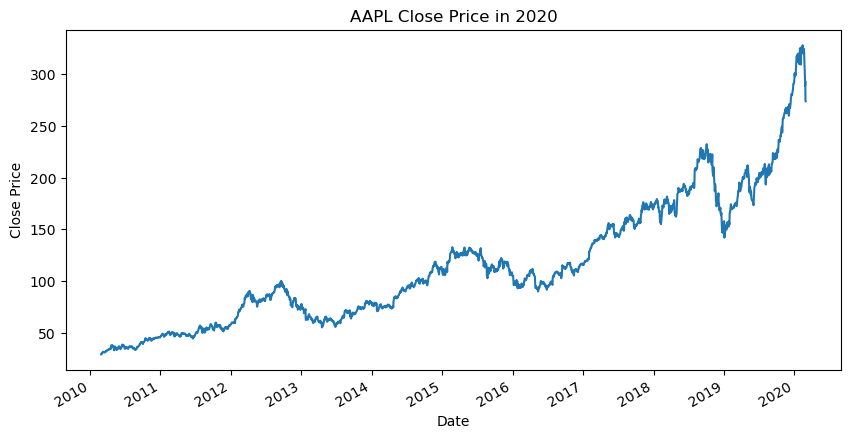

In [3]:
# Plot the Close price
ax = df['Close'].plot(title='AAPL Close Price in 2020', figsize=(10, 5))
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')

## 3. Forecasting Approaches

We now implement several forecasting approaches. We start with the simplest method and proceed to more advanced approaches.

### 3.1 Naive Forecast

The **Naive Forecast** simply uses the previous day's closing price as the forecast for the next day. Mathematically:

$$ y_{t+1} = y_t $$

This method is easy to implement and serves as a benchmark for more sophisticated methods.

In [4]:
# Create a copy of the data for the naive forecast
df_naive = df.copy()

# Shift the 'Close' column by one to get the naive forecast
df_naive['Naive Forecast'] = df_naive['Close'].shift(1)

df_naive.head(10)

,Close,Volume,Open,High,Low,Naive Forecast
Date,,,,,,
2010-03-01,29.86,137312041,29.39,29.93,29.35,NaN
2010-03-02,29.84,141486282,29.99,30.12,29.68,29.86
2010-03-03,29.90,92846488,29.85,29.98,29.71,29.84
2010-03-04,30.10,89591907,29.90,30.13,29.80,29.90
2010-03-05,31.28,224647427,30.71,31.39,30.66,30.10
2010-03-08,31.30,107326832,31.43,31.44,31.18,31.28
2010-03-09,31.86,229908139,31.19,32.14,31.13,31.30
2010-03-10,32.12,148907755,31.98,32.21,31.89,31.86
2010-03-11,32.21,101209110,31.99,32.21,31.90,32.12


### 3.2 Autoregressive (AR) Forecast

The **Autoregressive Forecast** (AR) uses the average of the previous 3 days' closing prices to predict the next day's closing price. The model is given by:

$$ y_{t+1} = \frac{y_t + y_{t-1} + y_{t-2}}{3} $$

This simple averaging can be seen as a basic AR(3) model.

In [5]:
# Define the autoregressive prediction function with a lag of 3
def autoregression_predict(data, lag=3):
    """
    Predicts the next value as the average of the last 'lag' values.
    """
    return np.mean(data[-lag:])

# Extract the closing prices
close_prices = df['Close'].values

# Set the lag value
lag = 3
ar_predictions = []

# Loop over the data starting at index 'lag'
for i in range(lag, len(close_prices)):
    past_values = close_prices[i-lag:i]
    pred = autoregression_predict(past_values, lag=lag)
    ar_predictions.append(pred)

# Create a new DataFrame for AR forecast (available from the 'lag'-th observation)
df_ar = df.iloc[lag:].copy()
df_ar['AR Forecast'] = ar_predictions

df_ar.head(10)

,Close,Volume,Open,High,Low,AR Forecast
Date,,,,,,
2010-03-04,30.10,89591907,29.90,30.13,29.80,29.87
2010-03-05,31.28,224647427,30.71,31.39,30.66,29.95
2010-03-08,31.30,107326832,31.43,31.44,31.18,30.43
2010-03-09,31.86,229908139,31.19,32.14,31.13,30.89
2010-03-10,32.12,148907755,31.98,32.21,31.89,31.48
2010-03-11,32.21,101209110,31.99,32.21,31.90,31.76
2010-03-12,32.37,103841951,32.48,32.53,32.25,32.06
2010-03-15,31.98,123005437,32.20,32.21,31.46,32.24
2010-03-16,32.06,111581993,32.03,32.14,31.79,32.19


### 3.3 Exponential Smoothing Forecast

The **Exponential Smoothing Forecast** computes a weighted average of past observations, with recent values receiving higher weight. The forecasting formula is:

$$ F_{t+1} = \alpha y_t + (1-\alpha) F_t $$

where \( \alpha \) is the smoothing factor. In this example, we use \( \alpha = 0.5 \).

In [6]:
# Define exponential smoothing function
def exponential_smoothing(series, alpha):
    forecasts = [series[0]]  # initial forecast is the first observation
    for t in range(1, len(series)):
        forecast = alpha * series[t-1] + (1 - alpha) * forecasts[-1]
        forecasts.append(forecast)
    return np.array(forecasts)

# Set smoothing factor alpha
alpha = 0.5
exp_smooth_forecasts = exponential_smoothing(close_prices, alpha)

# Create a DataFrame for exponential smoothing forecast
df_exp = df.copy()
df_exp['Exp Smooth Forecast'] = exp_smooth_forecasts

df_exp.head(10)

,Close,Volume,Open,High,Low,Exp Smooth Forecast
Date,,,,,,
2010-03-01,29.86,137312041,29.39,29.93,29.35,29.86
2010-03-02,29.84,141486282,29.99,30.12,29.68,29.86
2010-03-03,29.90,92846488,29.85,29.98,29.71,29.85
2010-03-04,30.10,89591907,29.90,30.13,29.80,29.88
2010-03-05,31.28,224647427,30.71,31.39,30.66,29.99
2010-03-08,31.30,107326832,31.43,31.44,31.18,30.63
2010-03-09,31.86,229908139,31.19,32.14,31.13,30.97
2010-03-10,32.12,148907755,31.98,32.21,31.89,31.41
2010-03-11,32.21,101209110,31.99,32.21,31.90,31.77


### 3.4 Linear Trend Forecast

In the **Linear Trend Forecast**, we assume the data can be modeled by a linear relationship:

$$ y_t = a + b\,t $$

We use NumPy's `polyfit` function to fit a line to the data and then use the resulting linear model to generate forecasts.

In [7]:
# Create a time index for the data
days = np.arange(len(close_prices))

# Fit a linear model (degree 1 polynomial)
coeff = np.polyfit(days, close_prices, deg=1)
linear_model = np.poly1d(coeff)

# Compute the linear trend forecast
linear_predictions = linear_model(days)

# Create a DataFrame for the linear trend forecast
df_linear = df.copy()
df_linear['Linear Trend Forecast'] = linear_predictions

df_linear.head(10)

,Close,Volume,Open,High,Low,Linear Trend Forecast
Date,,,,,,
2010-03-01,29.86,137312041,29.39,29.93,29.35,18.34
2010-03-02,29.84,141486282,29.99,30.12,29.68,18.42
2010-03-03,29.90,92846488,29.85,29.98,29.71,18.50
2010-03-04,30.10,89591907,29.90,30.13,29.80,18.57
2010-03-05,31.28,224647427,30.71,31.39,30.66,18.65
2010-03-08,31.30,107326832,31.43,31.44,31.18,18.73
2010-03-09,31.86,229908139,31.19,32.14,31.13,18.80
2010-03-10,32.12,148907755,31.98,32.21,31.89,18.88
2010-03-11,32.21,101209110,31.99,32.21,31.90,18.96


## 4. Comparison of Forecasting Approaches

We now combine the forecasts from all approaches into a single DataFrame and visualize them along with the actual closing prices. Note that the AR forecast is only available from the index corresponding to the chosen lag (i.e. from the 4th observation onward).

In [8]:
# Combine all forecasts into one DataFrame
df_combined = df.copy()

# Add Naive Forecast
df_combined['Naive Forecast'] = df_combined['Close'].shift(1)

# Add AR Forecast (fill beginning with NaN)
df_combined['AR Forecast'] = np.nan
df_combined.iloc[lag:, df_combined.columns.get_loc('AR Forecast')] = ar_predictions

# Add Exponential Smoothing Forecast
df_combined['Exp Smooth Forecast'] = exp_smooth_forecasts

# Add Linear Trend Forecast
df_combined['Linear Trend Forecast'] = linear_predictions

df_combined.head(15)

,Close,Volume,Open,High,Low,Naive Forecast,AR Forecast,Exp Smooth Forecast,Linear Trend Forecast
Date,,,,,,,,,
2010-03-01,29.86,137312041,29.39,29.93,29.35,NaN,NaN,29.86,18.34
2010-03-02,29.84,141486282,29.99,30.12,29.68,29.86,NaN,29.86,18.42
2010-03-03,29.90,92846488,29.85,29.98,29.71,29.84,NaN,29.85,18.50
2010-03-04,30.10,89591907,29.90,30.13,29.80,29.90,29.87,29.88,18.57
2010-03-05,31.28,224647427,30.71,31.39,30.66,30.10,29.95,29.99,18.65
2010-03-08,31.30,107326832,31.43,31.44,31.18,31.28,30.43,30.63,18.73
2010-03-09,31.86,229908139,31.19,32.14,31.13,31.30,30.89,30.97,18.80
2010-03-10,32.12,148907755,31.98,32.21,31.89,31.86,31.48,31.41,18.88
2010-03-11,32.21,101209110,31.99,32.21,31.90,32.12,31.76,31.77,18.96


Text(0, 0.5, 'Price')

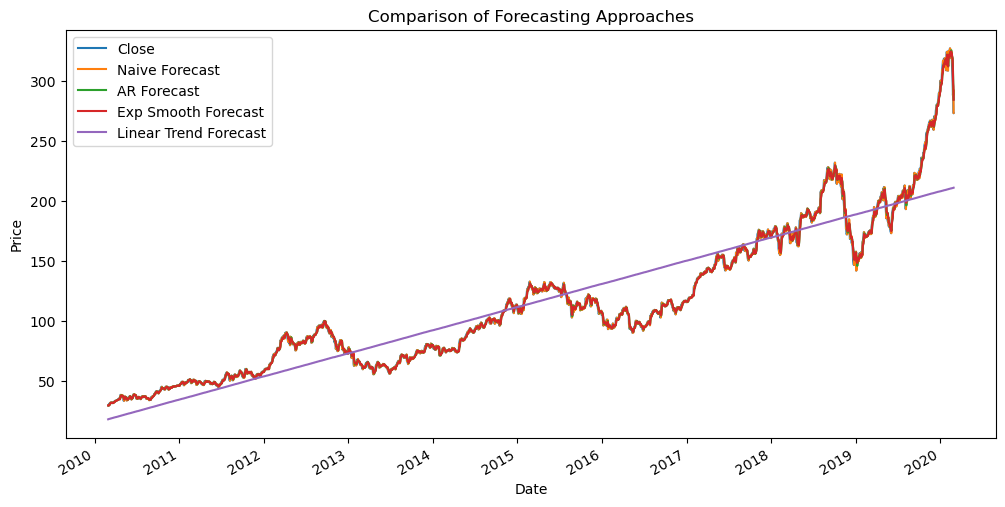

In [9]:
# Plot all forecasting approaches along with the actual Close price
ax = df_combined[["Close", "Naive Forecast", "AR Forecast", "Exp Smooth Forecast", "Linear Trend Forecast"]].plot(
    title='Comparison of Forecasting Approaches',
    figsize=(12, 6)
)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

Text(0, 0.5, 'Price')

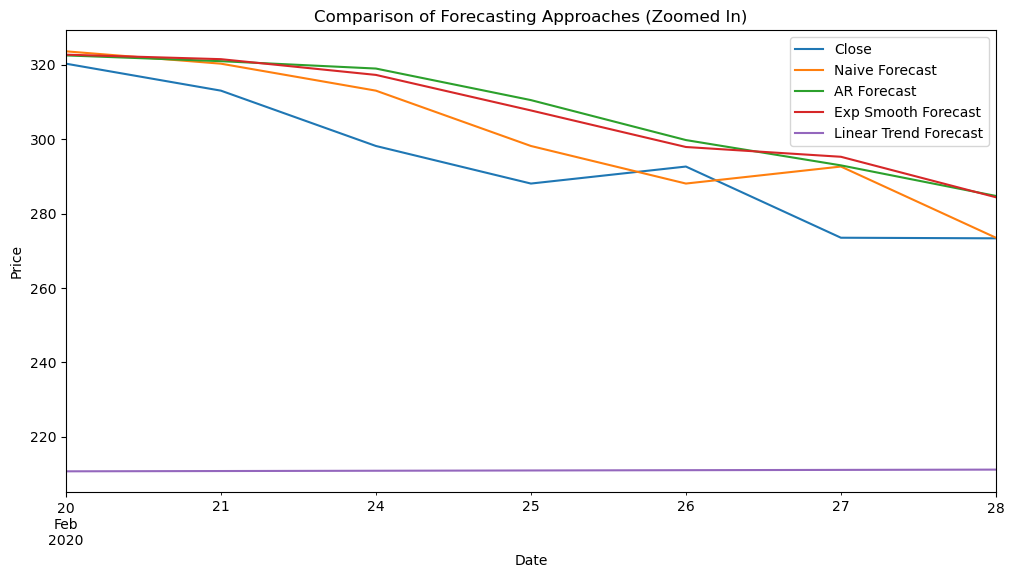

In [10]:
# Plot a zoomed-in version of the plot
start_date = '2020-02-20'
end_date = '2020-02-28'

ax = df_combined.loc[start_date:end_date, ["Close", "Naive Forecast", "AR Forecast", "Exp Smooth Forecast", "Linear Trend Forecast"]].plot(
    title='Comparison of Forecasting Approaches (Zoomed In)',
    figsize=(12, 6)
)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
# ax.set_ylim(150, 350)


## 5. Conclusion

In this notebook, we demonstrated multiple forecasting approaches for predicting AAPL's closing price:

- **Naive Forecast:** Assumes the next value is equal to the last observed value.
- **Autoregressive Forecast:** Uses the average of the previous 3 days' prices.
- **Exponential Smoothing Forecast:** Applies a weighted average with a smoothing factor \(\alpha\) to give more importance to recent observations.
- **Linear Trend Forecast:** Fits a simple linear model to capture the overall trend.

Each method has its own assumptions and can serve as a baseline for more advanced forecasting techniques. Experimenting with these methods and tuning their parameters can provide insights into their performance on real-world data.